# Finite element method: Poisson equation in 1D

Consider the Problem 
$$
\begin{aligned}
u''(x) &= f(x) &\text{in } \Omega = (0,1) \\
u(0) = u(1) &= 0
\end{aligned}
$$

Solve the problem using piecewise linear finite elements.
To evaluate the integral containing the function $f$, use the Simpson rule.

As a test problem, use the given solution $u(x) = \sin(\pi x)$. Plot the exact and numerical solution for $h = 0.2, 0.1, 0.05, 0.025$.

## Solution
We have 
$$
f(x) = \pi^2 \sin(\pi x) \; .
$$

In [1]:
f(x) = pi^2 * sin.(pi*x);

The element stiffness matrix $A_K$ is given by 
$$
A_K = \frac 1 h \cdot \begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix} \; .
$$
We enumerate the elements $(x_{j-1}, x_j)$ from the left to the right and assemble the global stiffness matrix.

In [8]:
using SparseArrays
function assemble_stiffness_matrix(h)
    nelements = convert(Int, 1/h)
    Ael = 1 / h * [1 -1; -1 1]
    A = spzeros(nelements + 1, nelements + 1)
    for i = 1 : nelements
        A[i:i+1,i:i+1] += Ael
    end
    # Dirichlet boundary conditions:
    A[1, 1:2] = [1 0]
    A[end, end-1:end] = [0 1]
    A
end
;

The element load vector $\ell_K$ is given by 
$$
(\ell_K)_i = \frac{h}{2} \int_{\hat K} f(F_K(\xi)) N_i(\xi) \; \mathrm d\xi \; , \quad i = 0,1 \; .
$$
We use the Simpson rule to evaluate these integrals.

In [3]:
function simpson(int)
    1 / 3 * (int(-1) + 4int(0) + int(1))
end
;

In [4]:
function assemble_load_vector(h, f)
    nelements = convert(Int, 1/h)
    l = zeros(nelements + 1)
    x = 0:h:1
    lel = [0.0, 0.0]
    for i = 1 : nelements
        m = (x[i] + x[i+1])/2
        int0(xi) = f(m + h * xi / 2) * (1 - xi)/2
        int1(xi) = f(m + h * xi / 2) * (1 + xi)/2
        lel[1] = simpson(int0)
        lel[2] = simpson(int1)
        l[i:i+1] += h / 2 * lel
    end
    # Dirichlet boundary:
    l[1] = l[end] = 0
    l
end
;

In [5]:
function solve(h, f)
    A = assemble_stiffness_matrix(h)
    rhs = assemble_load_vector(h, f)
    A \ rhs
end
;

In [6]:
function exact(range)
    sin.(pi*range)
end
;

We calculate the solutions for the different mesh sizes:

In [9]:
mesh_sizes = [0.2, 0.1, 0.05, 0.025]
numerical_solutions = [solve(h, f) for h in mesh_sizes]

4-element Array{Array{Float64,1},1}:
 [0.0, 0.587688, 0.950899, 0.950899, 0.587688, 0.0]                                                                                                                                               
 [0.0, 0.309014, 0.587779, 0.809009, 0.951047, 0.99999, 0.951047, 0.809009, 0.587779, 0.309014, 0.0]                                                                                              
 [0.0, 0.156434, 0.309017, 0.45399, 0.587785, 0.707106, 0.809016, 0.891006, 0.951056, 0.987688  …  0.987688, 0.951056, 0.891006, 0.809016, 0.707106, 0.587785, 0.45399, 0.309017, 0.156434, 0.0]  
 [0.0, 0.0784591, 0.156434, 0.233445, 0.309017, 0.382683, 0.45399, 0.522499, 0.587785, 0.649448  …  0.649448, 0.587785, 0.522499, 0.45399, 0.382683, 0.309017, 0.233445, 0.156434, 0.0784591, 0.0]

In [10]:
using PyPlot
function plot_numerical_solution(numsol, h)
    x = 0:0.01:1
    u = exact(x)
    plot(x, u)
    plot(0:h:1, numsol, "o-")
    xlabel("x")
    title(string("Exact and numerical solution for h = ", h))
    legend(("exact", "numerical"))
end
;

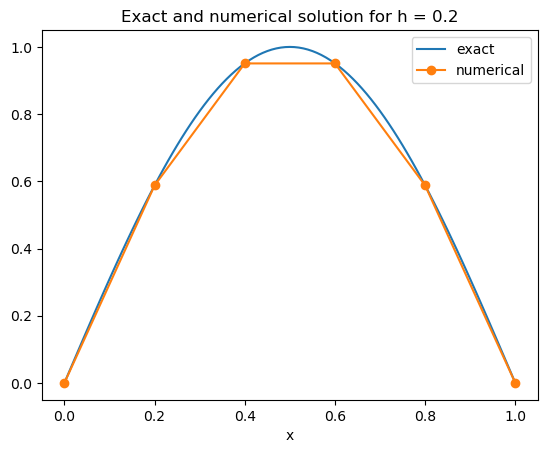

In [11]:
plot_numerical_solution(numerical_solutions[1], mesh_sizes[1]);

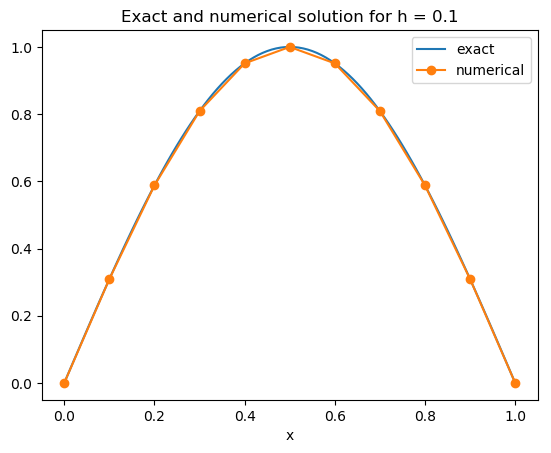

In [10]:
plot_numerical_solution(numerical_solutions[2], mesh_sizes[2]);

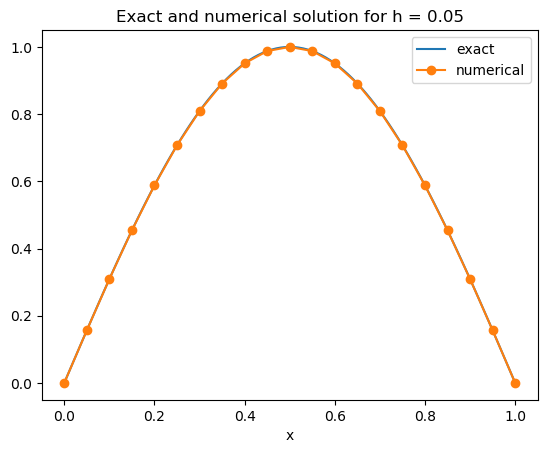

In [11]:
plot_numerical_solution(numerical_solutions[3], mesh_sizes[3]);

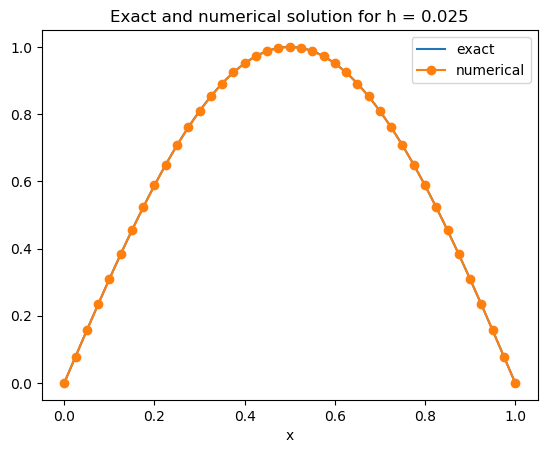

In [12]:
plot_numerical_solution(numerical_solutions[4], mesh_sizes[4]);

Finally, let's write a function to estimate the $L^2$-errors for our numerical solutions.

In [12]:
function l2error(numsol, h)
    u(s) = sin.(pi*s)
    x = 0:h:1
    err2 = 0.0
    m = 0.0
    numsol_m = 0.0
    for (i, p) in enumerate(x[1:end-1])
        m = p + h/2
        numsol_m = (numsol[i] + numsol[i+1]) / 2
        err2 += h / 6 * ((u(p) - numsol[i])^2 + 4*(u(m) - numsol_m)^2 + (u(p+h) - numsol[i+1])^2)
    end
    sqrt(err2)
end
;

In [13]:
l2_errors = [l2error(numsol, h) for (numsol, h) in zip(numerical_solutions, mesh_sizes)]

4-element Array{Float64,1}:
 0.028348529788153665 
 0.007113955640938079 
 0.0017801436767281597
 0.0004451390073814114

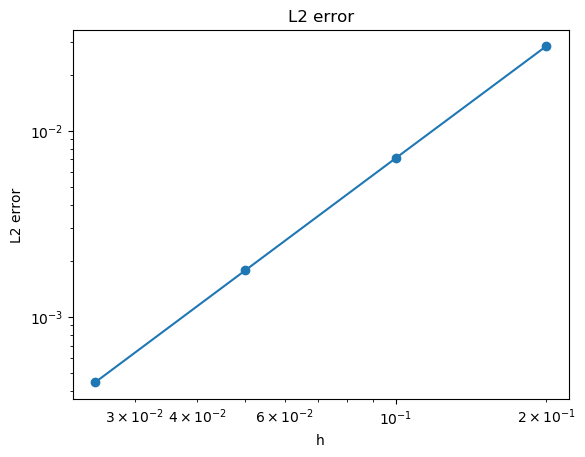

In [14]:
loglog(mesh_sizes, l2_errors, "o-")
title("L2 error")
xlabel("h")
ylabel("L2 error")
;